In [1]:
import os, sys, urllib, gzip
sys.path.append('/home/rui/pylearn2')
from __future__ import print_function
try:
    import cPickle as pickle
except:
    import pickle
sys.setrecursionlimit(10000)

import numpy as np
from lasagne.layers import get_output, InputLayer, DenseLayer, Upscale2DLayer, ReshapeLayer
from lasagne.nonlinearities import rectify, leaky_rectify, tanh
from lasagne.updates import nesterov_momentum
from lasagne.objectives import categorical_crossentropy
import pylearn2
from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayerFast
from lasagne.regularization import regularize_layer_params, l2, l1
import theano
import theano.tensor as T
import time
import lasagne
from lasagne.layers import Conv2DLayer as Conv2DLayerSlow
from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerSlow
try:
    from lasagne.layers.cuda_convnet import Conv2DCCLayer as Conv2DLayerFast
    from lasagne.layers.cuda_convnet import MaxPool2DCCLayer as MaxPool2DLayerFast
    print('Using cuda_convnet (faster)')
except ImportError:
    from lasagne.layers import Conv2DLayer as Conv2DLayerFast
    from lasagne.layers import MaxPool2DLayer as MaxPool2DLayerFast
    print('Using lasagne.layers (slower)')
import matplotlib
matplotlib.use('Agg') # Change matplotlib backend, in case we have no X server running..
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import Image as IPImage
from PIL import Image
from lasagne.regularization import regularize_network_params, l2, l1

Using gpu device 0: GeForce GTX 750 Ti (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 3007.)


Using cuda_convnet (faster)


## helper function

In [50]:
def get_layer_by_name(net, name):
    for i, layer in enumerate(lasagne.layers.get_all_layers(net)):
        if layer.name == name:
            return layer, i
    return None, None

In [51]:
data = np.load('output/simplest_straight_line_data.npz')
data1 = data['arr_0']
data_out1 = data['arr_1']
data2 = data['arr_2']
data_out2 = data['arr_3']

In [52]:
X = np.concatenate((data1,data2))
X = np.asarray(X, dtype = np.float32)
X = np.reshape(X, (60, 1, 72, 72))

In [53]:
data_out1.shape

(40, 72, 72)

In [54]:
data2.shape

(20, 72, 72)

In [55]:
X = X
X_out = X.reshape((X.shape[0], -1))

In [56]:
X1 = data1
X1_out = data_out1.reshape((data_out1.shape[0], -1))
X2 = data2
X2_out = data_out2.reshape((data_out2.shape[0], -1))
X1 = np.asarray(X1, dtype = np.float32)
X1_out = np.asarray(X1_out, dtype = np.float32)
X2 = np.asarray(X2, dtype = np.float32)
X2_out = np.asarray(X2_out, dtype = np.float32)
X1 = np.reshape(X1, (40, 1, 72, 72))
X2 = np.reshape(X2, (20, 1, 72, 72))

In [57]:
def get_picture_array(X, rescale=2):
    array = X.reshape(72,72)
    array = np.clip(array, a_min = 0, a_max = 255)
    return  array.repeat(rescale, axis = 0).repeat(rescale, axis = 1).astype(np.uint8())

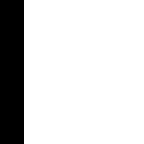

In [58]:
pic_array = get_picture_array(X[59]*255)
image = Image.fromarray(pic_array)
image.save('./output/temp.png', format="PNG")  
IPImage('./output/temp.png')

In [59]:
conv_num_filters = 16
pool_size = 2
encode_size = 16
pad_in = 'valid'    
pad_out = 'full'

In [60]:
def build_ARE(input_var=None):
    
    network = InputLayer(shape=(None,  X.shape[1], X.shape[2], X.shape[3]),input_var=input_var)
    
    network = Conv2DLayerFast(network, name= 'en_conv1_1', num_filters=conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=5, pad=pad_in)

    network = Conv2DLayerFast(network, name= 'en_conv1_2', num_filters=conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=5, pad=pad_in)

    network = MaxPool2DLayerFast(network, pool_size=pool_size)

    network = Conv2DLayerFast(network, name= 'en_conv2_1', num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=5, pad=pad_in)
    
    network = Conv2DLayerFast(network, name= 'en_conv2_2', num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=5, pad=pad_in)

    network = MaxPool2DLayerFast(network, pool_size=pool_size)
    
    network = Conv2DLayerFast(network, name= 'en_conv3_1', num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=3, pad=pad_in)
    
    network = Conv2DLayerFast(network, name= 'en_conv3_2', num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=3, pad=pad_in)
    
    network = ReshapeLayer(network, shape =(([0], -1)))
    
    
    encode_layer = DenseLayer(network, name= 'encode', num_units= encode_size, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify)
    
    action_layer = DenseLayer(encode_layer, name= 'action', num_units= encode_size, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify)
   
    network = DenseLayer(action_layer, num_units= 8*8*2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify)
    
    network = ReshapeLayer(network, shape =(([0], 2*conv_num_filters, 8, 8)))
    
    network = Conv2DLayerFast(network, name= 'de_conv1_1', num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=3, pad=pad_out)
    
    network = Conv2DLayerFast(network, name= 'de_conv1_2', num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=3, pad=pad_out)
    
    network = Upscale2DLayer(network, scale_factor = pool_size)
    
    network = Conv2DLayerFast(network, name= 'de_conv2_1', num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=5, pad=pad_out)
    
    network = Conv2DLayerFast(network, name= 'de_conv2_2', num_filters=2*conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=5, pad=pad_out)

    network = Upscale2DLayer(network, scale_factor = pool_size)
    
    network = Conv2DLayerFast(network, name= 'de_conv3_1', num_filters=conv_num_filters, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.rectify, filter_size=5, pad=pad_out)

    network = Conv2DLayerSlow(network, name= 'de_conv3_2', num_filters=1, W=lasagne.init.Orthogonal(1.0),\
                              nonlinearity=lasagne.nonlinearities.sigmoid, filter_size=5, pad=pad_out)
    
    network = ReshapeLayer(network, shape =(([0], -1)))

    return network

In [74]:
class ARE(object):
    def __init__(self, lambda1 = 5e-6, lambda2 = 0.1, name=None):
        self.name = name
        self.input_var = T.tensor4('inputs')
        self.target_var = T.matrix('targets')
        self.are_net = build_ARE(self.input_var)
        self.reconstructed = lasagne.layers.get_output(self.are_net)
        self.encode_layer, _ = get_layer_by_name(self.are_net, 'encode')
        self.action_layer, _ = get_layer_by_name(self.are_net, 'action')
        self.encoded_feature = lasagne.layers.get_output(self.encode_layer)
        self.l1_penalty = regularize_network_params(self.are_net, l1)
        self.loss = lasagne.objectives.squared_error(self.reconstructed, self.target_var)
        self.XXT = T.dot(self.encoded_feature, self.encoded_feature.transpose())
        self.loss = self.loss.mean() + lambda1 * self.l1_penalty + lambda2 * self.XXT.trace()
        self.loss = self.loss.mean() + lambda1 * self.l1_penalty
        self.params = lasagne.layers.get_all_params(self.are_net, trainable=True)
        self.best_err = 999
        self.action1_w = np.eye(encode_size, dtype = np.float32)
        self.action1_b = np.zeros(encode_size, dtype = np.float32)
        self.action2_w = np.eye(encode_size, dtype = np.float32)
        self.action2_b = np.zeros(encode_size, dtype = np.float32)
        self.action3_w = np.eye(encode_size, dtype = np.float32)
        self.action3_b = np.zeros(encode_size, dtype = np.float32)
        self.action4_w = np.eye(encode_size, dtype = np.float32)
        self.action4_b = np.zeros(encode_size, dtype = np.float32)
    
    def load_pretrained_model(self, file_name=None):
        if file_name==None:
            file_name = './output/straight_line/{}_ARE_best_err.npz'.format(self.name)
        with np.load(file_name) as f:
            param_values = [f['arr_%d' % i] for i in range(len(f.files))]
        lasagne.layers.set_all_param_values(self.are_net, param_values)
    
    def set_action_layer(self, action_id):
        if action_id == 1:
            self.action_layer.W.set_value(self.action1_w)
            self.action_layer.b.set_value(self.action1_b)
        elif action_id == 2:
            self.action_layer.W.set_value(self.action2_w)
            self.action_layer.b.set_value(self.action2_b)
        elif action_id == 3:
            self.action_layer.W.set_value(self.action3_w)
            self.action_layer.b.set_value(self.action3_b)
        elif action_id == 4:
            self.action_layer.W.set_value(self.action4_w)
            self.action_layer.b.set_value(self.action4_b)
        else:
            raise Exception('not a valid action')
    
    def get_action_layer(self, action_id):
        if action_id == 1:
            self.action1_w = self.action_layer.W.get_value()
            self.action1_b = self.action_layer.b.get_value()
        elif action_id == 2:
            self.action2_w = self.action_layer.W.get_value()
            self.action2_b = self.action_layer.b.get_value()
        elif action_id == 3:
            self.action3_w = self.action_layer.W.get_value()
            self.action3_b = self.action_layer.b.get_value()
        elif action_id == 4:
            self.action4_w = self.action_layer.W.get_value()
            self.action4_b = self.action_layer.b.get_value()
        else:
            raise Exception('not a valid action')
    
    
    def reset_loss(self, lambda1 = 5e-6, lambda2 = 0.1):
        self.loss = lasagne.objectives.squared_error(self.reconstructed, self.target_var)
        self.loss = self.loss.mean() + lambda1 * self.l1_penalty + lambda2 * self.XXT.trace()
    
    def train_network(self, learnrate=0.01,num_epochs=500, verbose = True, save_model = False):
        updates = lasagne.updates.nesterov_momentum(
            self.loss, self.params, learning_rate=learnrate, momentum=0.975)
        train_fn = theano.function([self.input_var, self.target_var], self.loss, updates=updates,on_unused_input='warn')
        if verbose:
            print("Starting training...")
        for epoch in range(num_epochs):
            start_time = time.time()
            train_err = train_fn(X, X_out)
            if verbose:
                print("Epoch {} of {} took {:.3f}s".format(
                    epoch + 1, num_epochs, time.time() - start_time))
                print(train_err)
                print("training loss:\t\t{:.6f}".format(float(train_err)))
            if save_model:
                if train_err < self.best_err:
                    self.best_err = train_err
                    #np.savez('./output/straight_line/CAE.npz', *lasagne.layers.get_all_param_values(self.are_net))
    
    def train_ARE_network(self, learnrate=0.01, num_epochs=500, verbose = True, save_model = False):
        updates = lasagne.updates.nesterov_momentum(
            self.loss, self.params, learning_rate=learnrate, momentum=0.975)
        train_fn = theano.function([self.input_var, self.target_var], self.loss, updates=updates,on_unused_input='warn')
        if verbose:
            print("Starting training...")
        for epoch in range(num_epochs):
            start_time = time.time()
            self.set_action_layer(1)
            train_err1 = train_fn(X1, X1_out)
            self.get_action_layer(1)
            self.set_action_layer(2)
            train_err2 = train_fn(X2, X2_out)
            self.get_action_layer(2)
            train_err = (train_err1 + train_err2)/2
            if verbose:
                print("Epoch {} of {} took {:.3f}s".format(
                    epoch + 1, num_epochs, time.time() - start_time))
                print(train_err)
                print("training loss:\t\t{:.6f}".format(float(train_err)))
            if save_model:
                if train_err < self.best_err:
                    self.best_err = train_err
                    np.savez('./output/straight_line/{}_ARE_best_err.npz'.format(self.name), *lasagne.layers.get_all_param_values(self.are_net))

In [68]:
X2_out.shape

(20, 5184)

In [75]:
simple_are = ARE(name = 'simplest')

In [77]:
simple_are.reset_loss(0, 5e-5)

In [78]:
#simple_are.train_ARE_network(learnrate=0.01,num_epochs=5000, verbose = False, save_model = True)
simple_are.load_pretrained_model()
simple_are.train_ARE_network(learnrate=0.005,num_epochs=5000, verbose = False, save_model = True)
simple_are.load_pretrained_model()
simple_are.train_ARE_network(learnrate=0.001,num_epochs=20000, verbose = False, save_model = True)
simple_are.load_pretrained_model()
simple_are.train_ARE_network(learnrate=0.0005,num_epochs=10000, verbose = False, save_model = True)

In [79]:
simple_are.best_err

0.0047234827652573586

In [80]:
simple_are.load_pretrained_model()


In [81]:
output_func = theano.function([simple_are.input_var], [lasagne.layers.get_output(simple_are.are_net)])
data_pred = np.zeros((40,72*72))
data_pred = output_func(X1)[0]

In [82]:
data_pred.shape

(40, 5184)

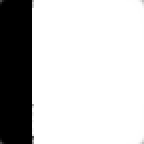

In [83]:
pic_array = get_picture_array(data_pred[19]*255)
image = Image.fromarray(pic_array)
image.save('temp.png', format="PNG")  
IPImage('temp.png')

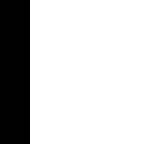

In [84]:
pic_array = get_picture_array(X[19]*255)
image = Image.fromarray(pic_array)
image.save('temp.png', format="PNG")  
IPImage('temp.png')

In [85]:
output_func = theano.function([simple_are.input_var], [lasagne.layers.get_output(simple_are.encode_layer)])
X_encode = output_func(X)[0]

In [87]:
from sklearn.decomposition import PCA
pca = PCA(10)
X_pcomp = pca.fit_transform(X_encode)

In [88]:
X_pcomp.shape

(60, 10)

## spectral plot of the learned hidden space

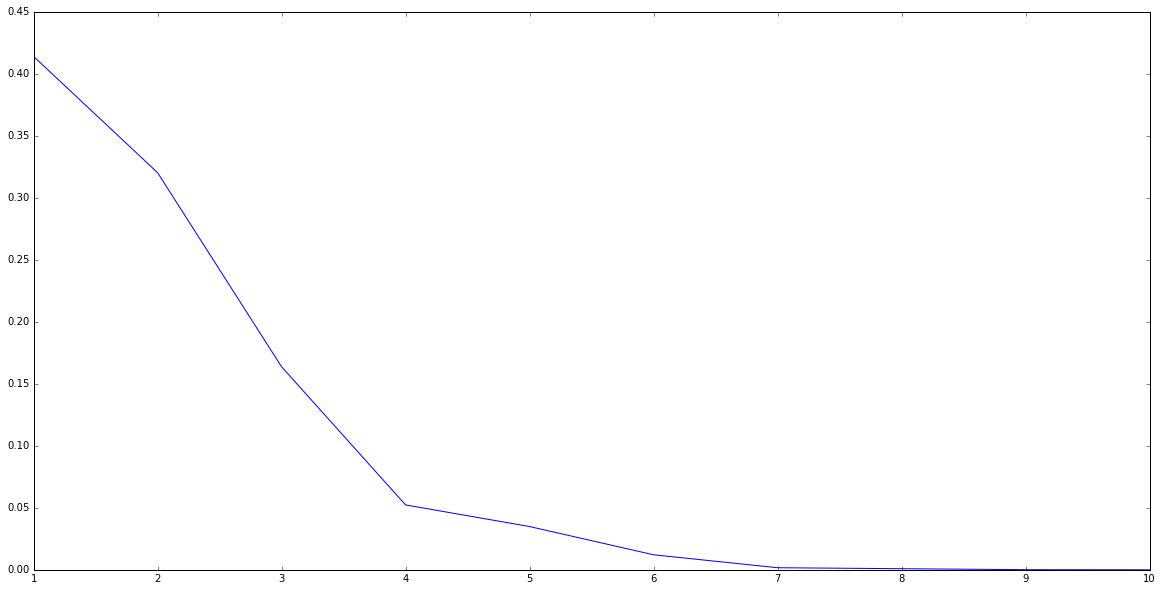

In [90]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(1,11),pca.explained_variance_ratio_)

# learned trajectory

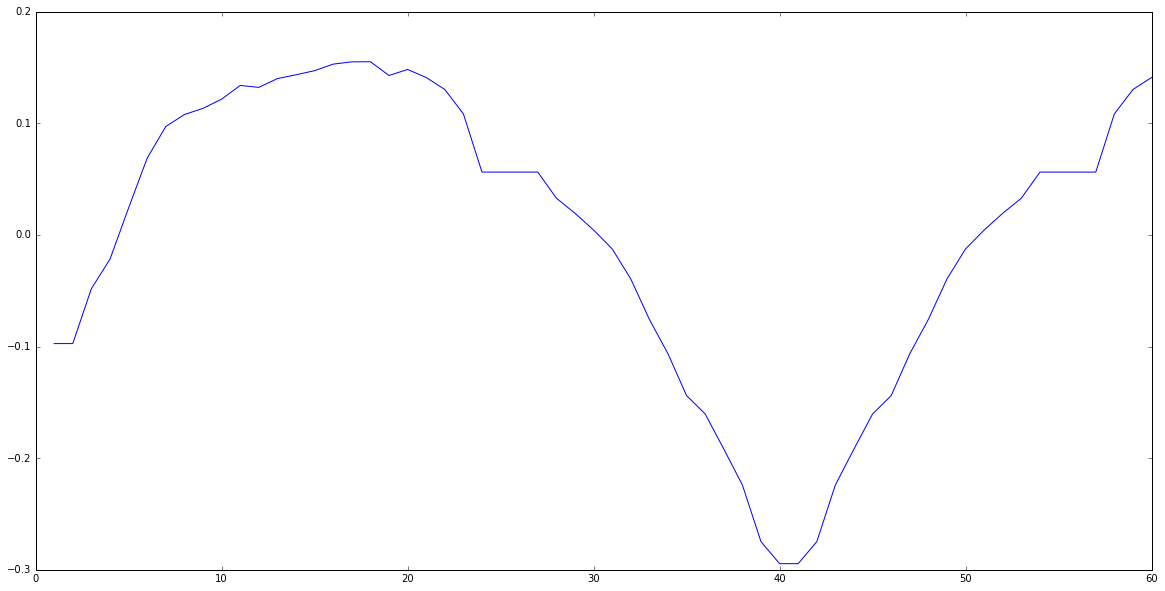

In [91]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(1,61),X_pcomp[:,0])

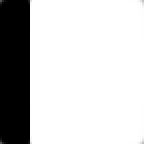

In [92]:
pic_array = get_picture_array(data_pred[20]*255)
image = Image.fromarray(pic_array)
image.save('temp.png', format="PNG")  
IPImage('temp.png')

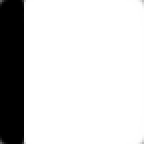

In [93]:
pic_array = get_picture_array(data_pred[21]*255)
image = Image.fromarray(pic_array)
image.save('temp.png', format="PNG")  
IPImage('temp.png')

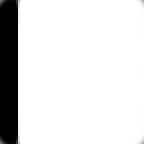

In [94]:
pic_array = get_picture_array(data_pred[22]*255)
image = Image.fromarray(pic_array)
image.save('temp.png', format="PNG")  
IPImage('temp.png')

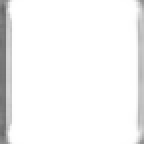

In [95]:
pic_array = get_picture_array(data_pred[23]*255)
image = Image.fromarray(pic_array)
image.save('temp.png', format="PNG")  
IPImage('temp.png')